### Dependencies

In [1]:
from pickle import dump, load

In [2]:
from modules import prep_IO

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
#ERROR: from imblearn.over_sampling import SMOTE

In [4]:
from sklearn.pipeline import Pipeline

#ERROR: from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.covariance import OAS
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

from sklearn.model_selection import GridSearchCV

In [5]:
#acct_ids_f = open( './jobid_dir/acct_ids', 'wb' )
#acct_ids_out = dump( acct_ids, acct_ids_f )
#acct_ids_f.close()

acct_ids_f = open( './jobid_dir/acct_ids', 'rb' )
acct_ids = load( acct_ids_f )
acct_ids_f.close()

### Setup data

In [6]:
id_hosts_f = open('ids_w_hosts.pkl', 'rb' )
id_w_hosts = load( id_hosts_f )
id_hosts_f.close()

# setup host info dict
host_info_b1_f = open( './jobid_dir/host_info_set_batch1.pkl', 'rb' )
host_info_sets = load( host_info_b1_f )
host_info_b1_f.close()

In [7]:
jobids_b1_f = open('./jobid_dir/jobids_batch1.pkl', 'rb' )
jobids_b1_dict = load( jobids_b1_f )
jobids_b1_f.close()

jobids_b2_f = open('./jobid_dir/jobids_batch2.pkl', 'rb' )
jobids_b2_dict = load( jobids_b2_f )
jobids_b2_f.close()

jobids_dict = { key:val for key,val in jobids_b1_dict.items() }
for key,val in jobids_b2_dict.items():
    jobids_dict[key] = val

print(len(jobids_dict))

hosts = list(jobids_dict.keys())

272


In [8]:
# pull in all valid saved jobids dict
valid_f = open('./jobid_dir/valid_batch1.pkl', 'rb' )
valid = load( valid_f )
valid_f.close() 

# setup list of job acct info paired with host info
paired_f = open( './jobid_dir/paired_batch2.pkl', 'rb' )
paired = load( paired_f )
paired_f.close()

In [9]:
len(valid)

34323

In [10]:
len(paired)

2519

#### Setup modeling parameters

In [11]:
LR_params = {
    'copy_X': [True],
    'fit_intercept': [True],
    'n_jobs': [None],
    'normalize': [False]
}

PCA_params = {
    'copy': [True],
    'iterated_power': ['auto'],
    'n_components': [None],
    'random_state': [None],
    'svd_solver': ['auto'],
    'tol': [0.0],
    'whiten': [False]
}

OAS_params = {
    'assume_centered': [False],
    'store_precision': [True]
}

DB_params = {
    'algorithm' : ['auto'],
    'eps' : [0.5],                  #maximum distance between two samples
    'leaf_size' : [30],
    'metric' : ['euclidean'],
    'metric_params' : [None],
    'min_samples' : [5, 20],
    'n_jobs' : [-1],
    'p' : [None]
}

#### Select subset of features for modeling

In [12]:
preselect_stats = [
    'block', 'cpu', 'intel_hsw',
    'llite', 'mem', 'osc', 'tmpfs', 'vfs'
]

preselect_schemas = [ 
    'rd_ios,E', 'wr_ios,E',
    'idle,E,U=cs',
    'FIXED_CTR0,E,W=48', 'FIXED_CTR1,E,W=48',
    'direct_read,E,U=B', 'direct_write,E,U=B', 'osc_read,E,U=B', 'osc_write,E,U=B',
    'MemTotal,U=KB', 'MemFree,U=KB', 'MemUsed,U=KB', 'Active,U=KB', 'Inactive,U=KB',
    'read_bytes,E,U=B', 'write_bytes,E,U=B',
    'bytes_used,U=B', 'files_used\n',
    'dentry_use', 'file_use', 'inode_use\n'
]

### Compile pre-selected feature data

In [13]:
features = {}
data = {}
descriptives = {}
labeled_sets = {}

for i in range( len( host_info_sets ) ):
    this_set = host_info_sets[ i ]
    these_ids = list(this_set.keys())
    
    for this_id in these_ids:
        this_dataset = this_set[ this_id ]['sample_dataset']
        this_labeled = prep_IO.labeled_data( this_dataset, times=False )
        these_features = list( this_labeled.keys() )
        
        #store labeled sets to inspect original data, if needed
        labeled_sets[ this_id ] = this_labeled
        
        if this_id not in data:
            data[ this_id ] = {}        
        
        for feature in these_features:
            
            if (feature[0] in preselect_stats) and (feature[2] in preselect_schemas):
                feature_data = this_labeled[ feature ]
                
                if feature not in features:
                    features[ feature ] = 1
                else:
                    features[ feature ] += 1
                
                if ( type(feature_data) is not list ):
                    descriptives[ feature ][ this_id ] = "Single val"                   
                else:    
                    # implement monotonic and increasing check
                    # decrement by 0th val if true
                    # resave feature_data to decremented list
                    temp = []
                    if ( prep_IO.monotonic( feature_data ) ) and \
                    ( feature_data[0] <= feature_data[-1] ):
                        
                        for j in range(len( feature_data )):
                            adj_val = feature_data[j] - feature_data[0]
                            temp.append( adj_val )
                        feature_data = temp
                    
                    # saving descriptives after potential decrement for monotonic inc data
                    if feature not in descriptives:
                        descriptives[ feature ] = {}
                    else:
                        if ( prep_IO.check_static( feature_data ) ):
                            descriptives[ feature ][ this_id ] = "Static"
                        else:
                            descriptives[ feature ][ this_id ] = prep_IO.get_stats( feature_data )
                            
                if feature not in data[ this_id ]:
                    data[ this_id ][ feature ] = [ np.mean( feature_data ) ]
                else:
                    data[ this_id ][ feature ].append( np.mean( feature_data ) )

In [14]:
# setup list of jobids to index data
found_ids = list( data.keys() )
len(found_ids)

515

In [15]:
matched = []
lost = []

for item in paired:
    for jobid in found_ids:
        if item['JobID'] == jobid:
            matched.append(jobid)

for jobid in found_ids:
    if jobid not in matched:
        lost.append(jobid)
        
for jobid in lost:
    del data[jobid]

In [16]:
# setup list of jobids to index data
found_ids = list( data.keys() )
len(found_ids)

501

### Preview State for Jobids in Sample

In [17]:
found_info = []

for item in paired:
    if item['JobID'] in found_ids:
        found_info.append( item )

len(found_info)

501

In [18]:
# count of states represented in sample
states = {}

# states for each jobid in sample
# will be appended to dataframe later on for category support
id_states = {}

for item in found_info:
    end_state = item['State']
    
    if 'CANCELLED' in end_state:
        end_state = 'CANCELLED'
    
    if end_state not in states:
        states[ end_state ] = 1
    else:
        states[ end_state ] += 1
    
    id_states[ item['JobID'] ] = end_state

states

{'TIMEOUT': 55, 'FAILED': 46, 'COMPLETED': 359, 'CANCELLED': 41}

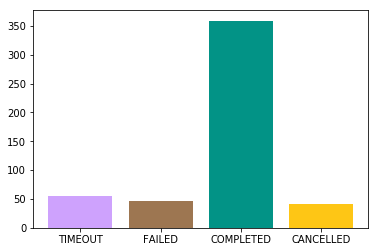

In [19]:
# Quick visualization of states
names = list(states.keys())
values = list(states.values())
colors = ['#cea2fd', '#9d7651', '#029386', '#fec615']
        
plt.bar(range(len(states)), values, tick_label=names, color=colors)
plt.show()

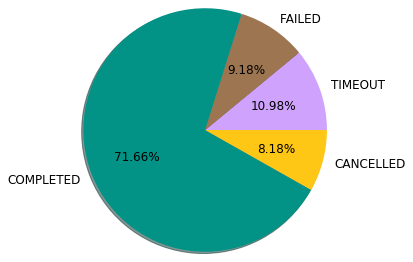

In [20]:
names = list(states.keys())
values = list(states.values())
colors = ['#cea2fd', '#9d7651', '#029386', '#fec615']
        
plt.pie(values, labels=names, colors=colors, autopct = "%0.2f%%",
        shadow=True, radius = 1.4, textprops={"fontsize":12})
plt.show()

### Sort static and non-static features/datapoints

In [21]:
# preview and purge static features from descriptive set
single_val_feats = {}
static_feats = {}
nonstatic_feats = {}

for feature, sample_dict in descriptives.items():
    job_keys = list( sample_dict.keys() )
    
    for key in job_keys:
        if sample_dict[ key ] == 'Single val':
            if feature not in static_feats:
                static_feats[ feature ] = [ key ]
            else:
                static_feats[ feature ].append( key )
        elif sample_dict[ key ] == 'Static':
            if feature not in static_feats:
                static_feats[ feature ] = [ key ]
            else:
                static_feats[ feature ].append( key )
        else:
            if feature not in nonstatic_feats:
                nonstatic_feats[ feature ] = { key: sample_dict[key] }
            else:
                nonstatic_feats[ feature ][ key ] = sample_dict[ key ]

Inspect number of jobids with correspondingly static feature data

In [22]:
for feat, job_list in static_feats.items():
    print( feat )
    print( len( job_list ) )
    print()

('block', 'md0', 'rd_ios,E')
513

('block', 'md0', 'wr_ios,E')
514

('block', 'md1', 'rd_ios,E')
115

('block', 'md1', 'wr_ios,E')
60

('block', 'sda', 'rd_ios,E')
114

('block', 'sda', 'wr_ios,E')
61

('block', 'sdb', 'rd_ios,E')
121

('block', 'sdb', 'wr_ios,E')
60

('cpu', '22', 'idle,E,U=cs')
79

('cpu', '20', 'idle,E,U=cs')
92

('cpu', '21', 'idle,E,U=cs')
93

('cpu', '11', 'idle,E,U=cs')
110

('cpu', '10', 'idle,E,U=cs')
99

('cpu', '13', 'idle,E,U=cs')
85

('cpu', '12', 'idle,E,U=cs')
94

('cpu', '15', 'idle,E,U=cs')
82

('cpu', '14', 'idle,E,U=cs')
82

('cpu', '17', 'idle,E,U=cs')
93

('cpu', '16', 'idle,E,U=cs')
90

('cpu', '19', 'idle,E,U=cs')
73

('cpu', '18', 'idle,E,U=cs')
90

('cpu', '23', 'idle,E,U=cs')
80

('cpu', '1', 'idle,E,U=cs')
92

('cpu', '0', 'idle,E,U=cs')
100

('cpu', '3', 'idle,E,U=cs')
92

('cpu', '2', 'idle,E,U=cs')
97

('cpu', '5', 'idle,E,U=cs')
95

('cpu', '4', 'idle,E,U=cs')
96

('cpu', '7', 'idle,E,U=cs')
88

('cpu', '6', 'idle,E,U=cs')
96

('cpu', '9'

Collect jobids with non-static feature data

In [23]:
nonstatic_labels = list( nonstatic_feats.keys() )
nonstatic_ids = []

for feat, sample_dict in nonstatic_feats.items():
    keys = list( sample_dict.keys() )
    for key in keys:
        if key not in nonstatic_ids:
            nonstatic_ids.append( key )
        
len(nonstatic_ids)

454

In [24]:
# preview top nonstatic feature descriptives
print( nonstatic_labels[1] )
nonstatic_feats[ nonstatic_labels[1] ]

('block', 'md1', 'rd_ios,E')


{'26811259': {'Count': 3,
  'Min': 0,
  'Max': 168,
  'Quartiles': array([ 82.5, 165. , 166.5]),
  'Mean': 111.0,
  'Std. Dev': 78.49840762716146,
  'Values': [0, 165, 168]},
 '26806765': {'Count': 2,
  'Min': 0,
  'Max': 15738,
  'Quartiles': array([ 3934.5,  7869. , 11803.5]),
  'Mean': 7869.0,
  'Std. Dev': 7869.0,
  'Values': [0, 15738]},
 '26806804': {'Count': 2,
  'Min': 0,
  'Max': 15553,
  'Quartiles': array([ 3888.25,  7776.5 , 11664.75]),
  'Mean': 7776.5,
  'Std. Dev': 7776.5,
  'Values': [0, 15553]},
 '26795026': {'Count': 77,
  'Min': 0,
  'Max': 19906,
  'Mode': 19906,
  'Quartiles': array([ 5377., 19900., 19904.]),
  'Mean': 15288.662337662337,
  'Std. Dev': 7089.240218316567,
  'Skew': -0.9055174273176491,
  'Values': [0,
   3696,
   3768,
   4075,
   4277,
   4349,
   4436,
   4450,
   4460,
   4471,
   4481,
   4494,
   4505,
   4516,
   4525,
   4536,
   5345,
   5355,
   5366,
   5377,
   5387,
   5398,
   5408,
   19865,
   19865,
   19865,
   19865,
   19865,
   1

### Aggregate feature data by devices

In [25]:
agg_data = {}

for this_id in found_ids:
    catch = {}
    
    if this_id not in agg_data:
        agg_data[ this_id ] = {}
    
    for feature, datum in data[ this_id ].items():
        agg_label = ( feature[0], feature[2] )
        
        if agg_label not in catch:
            catch[ agg_label ] = [datum]
        else:
            catch[ agg_label ].append( datum )
        
    for label, data_list in catch.items():
        try:
            agg_val = np.mean( data_list )
            agg_data[ this_id ][ label ] = agg_val
            
        except:
            bucket = []
            for item in data_list:
                if type(item) == list:
                    for val in item:
                        bucket.append( val )
                else:
                    bucket.append(item)
                    
            agg_val = np.mean( bucket )
            agg_data[ this_id ][ label ] = agg_val

In [26]:
# setup as DataFrame
agg_df = pd.DataFrame( agg_data ).T#.astype(np.float64)
indices = agg_df.index
agg_df.reset_index( drop=True, inplace=True )
agg_df.head()

block                         cpu         intel_hsw                    \
    rd_ios,E      wr_ios,E   idle,E,U=cs FIXED_CTR0,E,W=48 FIXED_CTR1,E,W=48   
0   0.611538  51398.676923  26721.493590      1.262694e+14      1.028528e+14   
1   1.367647  11265.823529     37.848039      3.912546e+13      1.346674e+13   
2  22.261111  27194.738889      4.998148      8.702386e+13      3.696165e+13   
3   0.000000  87606.937500  30008.583333      2.943290e+12      8.212056e+12   
4  36.125000  40065.875000   6799.562500      7.844556e+11      5.447708e+11   

              llite                                                    \
  direct_read,E,U=B direct_write,E,U=B osc_read,E,U=B osc_write,E,U=B   
0               0.0                0.0            0.0             0.0   
1               0.0                0.0            0.0             0.0   
2               0.0                0.0            0.0             0.0   
3               0.0                0.0            0.0             0.0   
4               0.0                0.0            0.0             0.0   

                        ...                 mem                              \
  read_bytes,E,U=B      ...        MemFree,U=KB MemTotal,U=KB  MemUsed,U=KB   
0     0.000000e+00      ...        3.554410e+07           0.0  3.133960e+07   
1     3.934473e+08      ...        5.600827e+07           0.0  1.087544e+07   
2     0.000000e+00      ...        6.420002e+07           0.0  2.683683e+06   
3     1.344375e+03      ...        3.507189e+07           0.0  3.181182e+07   
4     8.962500e+02      ...        3.650010e+07           0.0  1.234491e+06   

               osc                            tmpfs               \
  read_bytes,E,U=B write_bytes,E,U=B bytes_used,U=B files_used\n   
0     2.250000e+01      32491.569231   0.000000e+00     0.000000   
1     3.934473e+08          0.000000   1.259679e+08    13.411765   
2     0.000000e+00          0.000000   1.291125e+08     7.911111   
3     1.344375e+03          0.000000   0.000000e+00     0.000000   
4     1.748750e+03     474157.750000   0.000000e+00     0.000000   

             vfs                              
      dentry_use     file_use    inode_use\n  
0   14706.461538   839.630769   67917.707692  
1   14151.823529  1987.764706  151851.235294  
2   14540.866667  2674.133333   51070.444444  
3  176718.250000  1716.000000      76.500000  
4  176748.500000   120.000000  910107.000000  

[5 rows x 23 columns]

In [27]:
# Drop any column which has the same value for all rows
nunique = agg_df.apply( pd.Series.nunique )
cols_to_drop = nunique[ nunique == 1 ].index
agg_df = agg_df.drop( cols_to_drop, axis=1 )
agg_df.head()

block                         cpu         intel_hsw                    \
    rd_ios,E      wr_ios,E   idle,E,U=cs FIXED_CTR0,E,W=48 FIXED_CTR1,E,W=48   
0   0.611538  51398.676923  26721.493590      1.262694e+14      1.028528e+14   
1   1.367647  11265.823529     37.848039      3.912546e+13      1.346674e+13   
2  22.261111  27194.738889      4.998148      8.702386e+13      3.696165e+13   
3   0.000000  87606.937500  30008.583333      2.943290e+12      8.212056e+12   
4  36.125000  40065.875000   6799.562500      7.844556e+11      5.447708e+11   

             llite                             mem                 \
  read_bytes,E,U=B write_bytes,E,U=B   Active,U=KB  Inactive,U=KB   
0     0.000000e+00       1084.146154  1.038664e+07  417600.892308   
1     3.934473e+08          0.000000  7.951287e+06  739867.764706   
2     0.000000e+00          0.000000  5.732589e+05  159219.200000   
3     1.344375e+03      17254.000000  6.605678e+06    1826.000000   
4     8.962500e+02     438812.750000  2.490431e+06    1012.000000   

                                                         osc  \
   MemFree,U=KB MemTotal,U=KB  MemUsed,U=KB read_bytes,E,U=B   
0  3.554410e+07           0.0  3.133960e+07     2.250000e+01   
1  5.600827e+07           0.0  1.087544e+07     3.934473e+08   
2  6.420002e+07           0.0  2.683683e+06     0.000000e+00   
3  3.507189e+07           0.0  3.181182e+07     1.344375e+03   
4  3.650010e+07           0.0  1.234491e+06     1.748750e+03   

                             tmpfs                         vfs               \
  write_bytes,E,U=B bytes_used,U=B files_used\n     dentry_use     file_use   
0      32491.569231   0.000000e+00     0.000000   14706.461538   839.630769   
1          0.000000   1.259679e+08    13.411765   14151.823529  1987.764706   
2          0.000000   1.291125e+08     7.911111   14540.866667  2674.133333   
3          0.000000   0.000000e+00     0.000000  176718.250000  1716.000000   
4     474157.750000   0.000000e+00     0.000000  176748.500000   120.000000   

                  
     inode_use\n  
0   67917.707692  
1  151851.235294  
2   51070.444444  
3      76.500000  
4  910107.000000

## Setup Y data
- __FIXED_CTR0__ Instructions Retired
- __FIXED_CTR1__ Core Clock Cycles
- __FIXED_CTR2__ Reference Clock Cycles

In [28]:
cores = agg_df['intel_hsw', 'FIXED_CTR1,E,W=48']
instrs = agg_df['intel_hsw', 'FIXED_CTR0,E,W=48']

agg_df[ 'CPI' ] = cores / instrs / 24

agg_df = agg_df.drop( ['FIXED_CTR0,E,W=48', 'FIXED_CTR1,E,W=48'], axis=1, level=1 )

In [29]:
# Separate X and Y sets
Y = agg_df[['CPI']]
X = agg_df.drop(['CPI'], axis = 1)

X.shape

(501, 17)

In [30]:
# Customized scaling by max value in each column
# Several library scalers attempted previously: StandardScaler, MinMaxScaler, RobustScaler
# Data in each column too distinct to support these scalers, warps overall values
# NOTE: This is done after separating Y cols so as not to inappropriately skew the CPI data
max_by_col = {}

for row,col in X.items():
    max_by_col[ row ] = max( col )

for col_label in max_by_col.keys():
    X[ col_label ] = X[ col_label ] / max_by_col[ col_label ]

X.head()

block                     cpu            llite                    \
       rd_ios,E  wr_ios,E   idle,E,U=cs read_bytes,E,U=B write_bytes,E,U=B   
0  6.990674e-08  0.000407  2.070510e-04     0.000000e+00      2.125366e-10   
1  1.563397e-07  0.000089  2.932648e-07     1.024664e-06      0.000000e+00   
2  2.544732e-06  0.000215  3.872806e-08     0.000000e+00      0.000000e+00   
3  0.000000e+00  0.000693  2.325209e-04     3.501186e-12      3.382483e-09   
4  4.129554e-06  0.000317  5.268628e-05     2.334124e-12      8.602507e-08   

          mem                                                        \
  Active,U=KB Inactive,U=KB MemFree,U=KB MemTotal,U=KB MemUsed,U=KB   
0    0.207362      0.016349     0.547372           0.0     0.566248   
1    0.158742      0.028965     0.862516           0.0     0.196499   
2    0.011445      0.006233     0.988667           0.0     0.048489   
3    0.131878      0.000071     0.540100           0.0     0.574780   
4    0.049720      0.000040     0.562094           0.0     0.022305   

               osc                            tmpfs                     vfs  \
  read_bytes,E,U=B write_bytes,E,U=B bytes_used,U=B files_used\n dentry_use   
0     1.610114e-11      6.662692e-09       0.000000     0.000000   0.083206   
1     2.815533e-04      0.000000e+00       0.045577     0.000327   0.080068   
2     0.000000e+00      0.000000e+00       0.046715     0.000193   0.082269   
3     9.620429e-10      0.000000e+00       0.000000     0.000000   0.999829   
4     1.251416e-09      9.723037e-08       0.000000     0.000000   1.000000   

                         
   file_use inode_use\n  
0  0.000851    0.074626  
1  0.002014    0.166850  
2  0.002710    0.056115  
3  0.001739    0.000084  
4  0.000122    1.000000

## Prep data for training

In [31]:
# Separate into train/test sets
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, )

# Begin Training

In [32]:
pca = PCA().fit( X )

In [33]:
pca.explained_variance_ratio_

array([5.97474384e-01, 1.35835433e-01, 8.76641413e-02, 5.60669391e-02,
       3.81040200e-02, 2.42037329e-02, 1.58349929e-02, 1.22157750e-02,
       1.12879078e-02, 7.85713902e-03, 7.56012157e-03, 3.22584321e-03,
       2.43736062e-03, 2.04691456e-04, 2.56049260e-05, 1.38413740e-06,
       5.29647598e-07])

In [34]:
pca.singular_values_

array([1.15843757e+01, 5.52356570e+00, 4.43735302e+00, 3.54867652e+00,
       2.92548845e+00, 2.33160063e+00, 1.88591418e+00, 1.65643158e+00,
       1.59228101e+00, 1.32844998e+00, 1.30309890e+00, 8.51205883e-01,
       7.39899755e-01, 2.14418793e-01, 7.58358836e-02, 1.76320411e-02,
       1.09070296e-02])

In [35]:
pca_df = pd.DataFrame( pca.components_, columns=list( X.columns ) )
pca_df

,"(block, rd_ios,E)","(block, wr_ios,E)","(cpu, idle,E,U=cs)","(llite, read_bytes,E,U=B)","(llite, write_bytes,E,U=B)","(mem, Active,U=KB)","(mem, Inactive,U=KB)","(mem, MemFree,U=KB)","(mem, MemTotal,U=KB)","(mem, MemUsed,U=KB)","(osc, read_bytes,E,U=B)","(osc, write_bytes,E,U=B)","(tmpfs, bytes_used,U=B)","(tmpfs, files_used )","(vfs, dentry_use)","(vfs, file_use)","(vfs, inode_use )"
0,0.214234,0.317030,0.450663,0.202435,0.285972,-0.008093,0.012701,-0.004075,0.570228,0.037283,0.308711,0.289107,-0.006858,-0.001947,0.084435,-0.001897,0.121970
1,0.019230,-0.043383,-0.032134,-0.015637,-0.007204,0.430306,0.078342,-0.649495,-0.037415,0.535394,-0.031192,-0.006686,0.020272,0.011077,0.253181,0.012117,0.171552
2,0.393049,-0.023125,-0.372155,0.410291,0.429871,0.031380,0.010490,-0.019217,-0.292244,0.029577,-0.132826,0.437842,0.004043,-0.000509,-0.122643,-0.000340,-0.202977
3,0.133325,-0.089984,-0.105671,0.061606,0.047469,-0.343333,0.034322,0.009563,-0.101418,-0.235714,-0.173511,0.048728,-0.011365,0.021735,0.629897,0.022493,0.584431
4,-0.198597,0.184261,-0.071036,0.004100,0.019808,-0.021201,-0.013241,-0.013108,-0.095654,-0.079852,0.270435,0.019794,0.031458,0.045631,0.654299,0.045862,-0.630889
5,-0.072952,0.029373,-0.001713,-0.000192,0.011108,-0.419573,-0.012114,-0.743370,0.015460,-0.404170,0.098253,0.012059,-0.123762,-0.088383,-0.224884,-0.089376,-0.099100
6,-0.491160,0.034918,-0.328568,0.076920,0.149320,0.040254,-0.021255,0.084719,-0.164914,0.050003,0.636574,0.160274,-0.011924,-0.030237,-0.125488,-0.030287,0.365775
7,-0.030276,-0.002123,-0.001180,0.021087,0.007757,-0.009568,-0.142787,-0.118721,0.015311,-0.121137,0.016720,0.008087,0.496920,0.587836,-0.101219,0.586829,0.040620
8,-0.025292,-0.220953,-0.004859,-0.069640,0.032685,-0.358283,0.834651,0.045127,0.069977,0.258637,0.081174,0.040857,0.111742,0.079356,-0.046977,0.079777,-0.100743
9,0.058124,0.631294,0.011355,0.036432,-0.100642,-0.028893,0.175700,-0.016521,-0.256831,-0.011325,-0.070515,-0.117012,0.590306,-0.232231,-0.061318,-0.232355,0.098137


In [36]:
imp_feats = {}

for row,col in pca_df.items():
    for val in col.values:
        if val > 0.20:
            if row not in imp_feats:
                imp_feats[ row ] = [val]
            else:
                imp_feats[ row ].append( val )
                
imp_feats

{('block', 'rd_ios,E'): [0.21423446457613843,
  0.39304870818982496,
  0.46420312109857403,
  0.20048941057393052,
  0.4009366287104395,
  0.2674972253750397],
 ('block', 'wr_ios,E'): [0.3170295244103651, 0.6312941184707964],
 ('cpu', 'idle,E,U=cs'): [0.4506625439974628, 0.38080957023814355],
 ('llite', 'read_bytes,E,U=B'): [0.2024346555402177,
  0.4102910535646086,
  0.51026160595799],
 ('llite', 'write_bytes,E,U=B'): [0.2859724261268386,
  0.42987102050808434,
  0.7383216071885006],
 ('mem', 'Active,U=KB'): [0.43030590426490356, 0.5820777620847286],
 ('mem', 'Inactive,U=KB'): [0.8346513711858455, 0.39106170907264143],
 ('mem', 'MemTotal,U=KB'): [0.570227824663841,
  0.23547525636668798,
  0.44078391008657825],
 ('mem', 'MemUsed,U=KB'): [0.5353935415950921,
  0.25863746257047954,
  0.20838568319805242],
 ('osc', 'read_bytes,E,U=B'): [0.3087110417058476,
  0.2704346449712914,
  0.6365737754078927,
  0.3384796551152388,
  0.24614450655949704,
  0.3899392693305579],
 ('osc', 'write_bytes

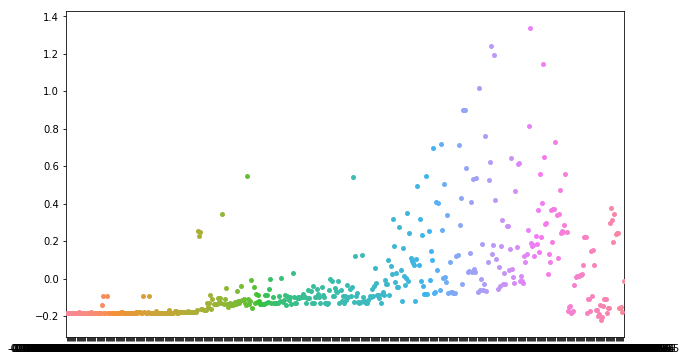

In [37]:
X_trans = pca.transform(X)   

Xs = X_trans[:,0:2][:,0]
Ys = X_trans[:,0:2][:,1]
n = pca.components_.shape[0]

fig, ax = plt.subplots(figsize=(10, 6))
sns.stripplot( Xs, Ys, c='blue' )

#for i in range(n):
#    ax.arrow(0, 0, pca.components_[i,0], pca.components_[i,1], color = 'r',alpha = 0.5)
#    ax.text( pca.components_[i,0]* 1.15, pca.components_[i,1] * 1.15, X.columns[i], color = 'g', ha = 'center', va = 'center')

plt.show()

DBSCAN
- default parameters

In [38]:
models = []

In [39]:
# Model 1: default parameters
DB = DBSCAN().fit( X )
models.append( DB )    

In [48]:
labels = DB_model.labels_
labels

array([ 0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [50]:
first = sum([ 1 for val in labels if val == 0 ])
print(first)

second = sum([ 1 for val in labels if val == 1 ])
print(second)

third = sum([ 1 for val in labels if val == 2 ])
print(third)

fourth = sum([ 1 for val in labels if val == 3 ])
print(fourth)

fifth = sum([ 1 for val in labels if val == 4 ])
print(fifth)

sixth = sum([ 1 for val in labels if val == 5 ])
print(sixth)

seventh = sum([ 1 for val in labels if val == 6 ])
print(seventh)

442
10
8
8
5
10
7


In [41]:
n_groups = []

for val in models[0].labels_:
    if (val != -1) and (val not in n_groups):
        n_groups.append( val )

n_groups

[0, 1, 2, 3, 4, 5, 6]

In [42]:
DB.components_.shape

(486, 17)

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('block', 'rd_ios,E')")

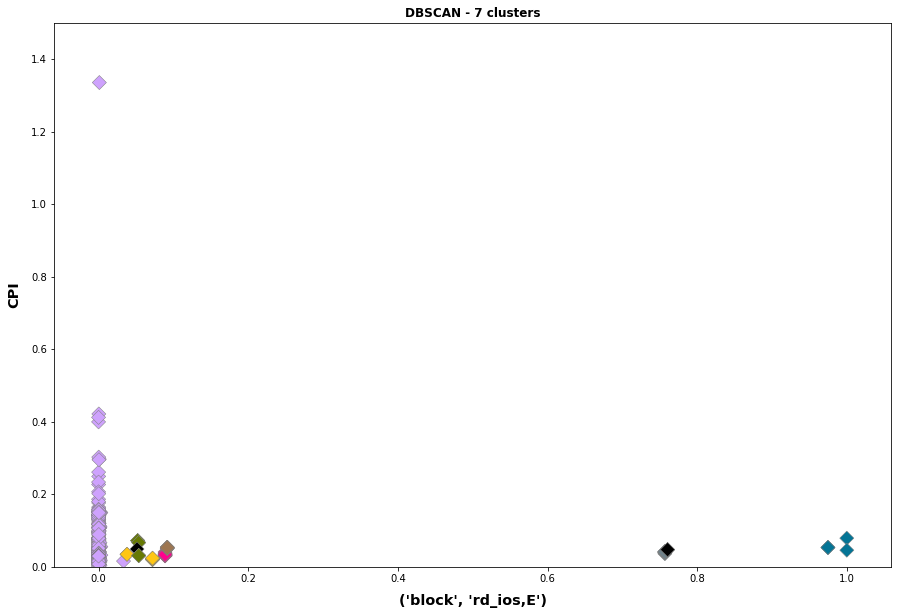

In [174]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( X.values[:,0], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[0]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('block', 'wr_ios,E')")

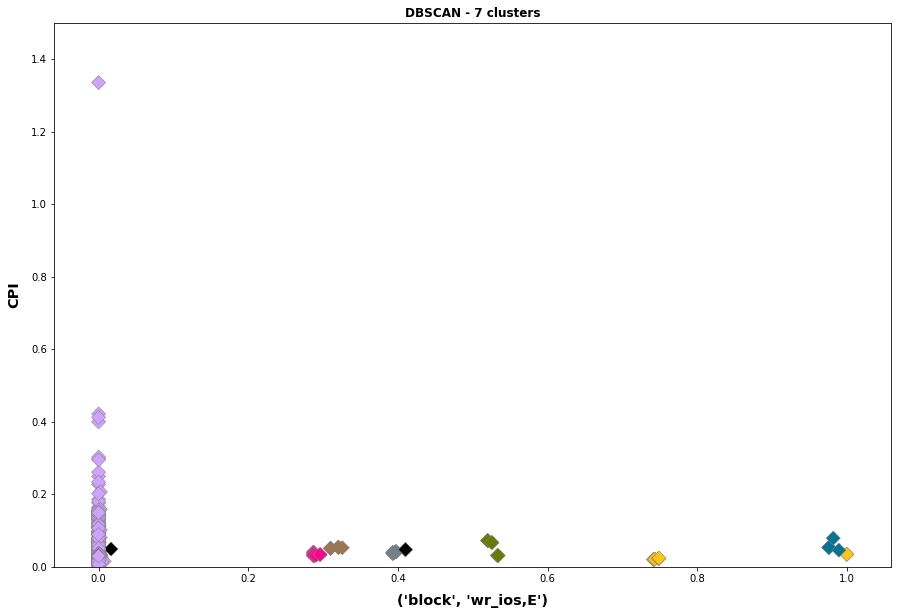

In [175]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( X.values[:,1], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[1]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('cpu', 'idle,E,U=cs')")

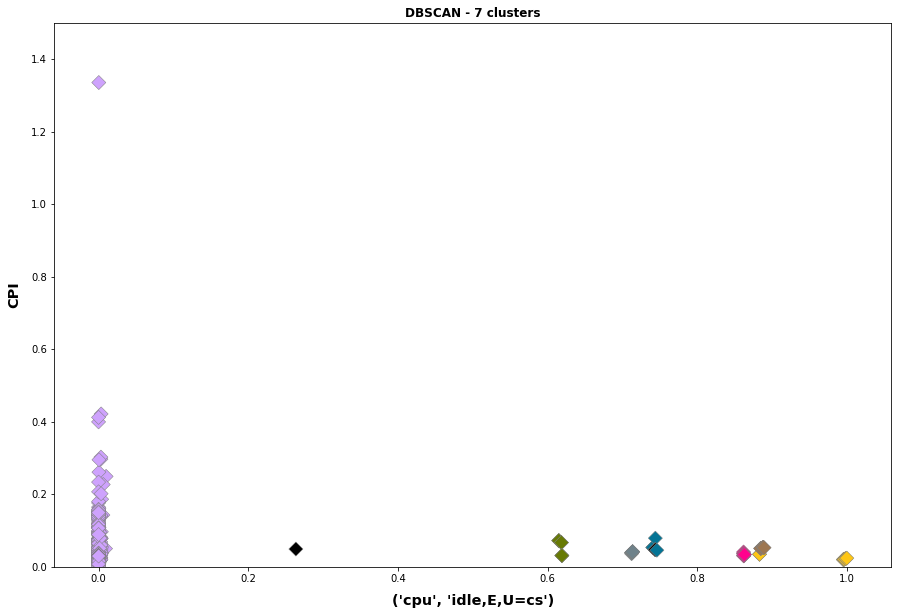

In [176]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( X.values[:,2], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[2]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('llite', 'write_bytes,E,U=B')")

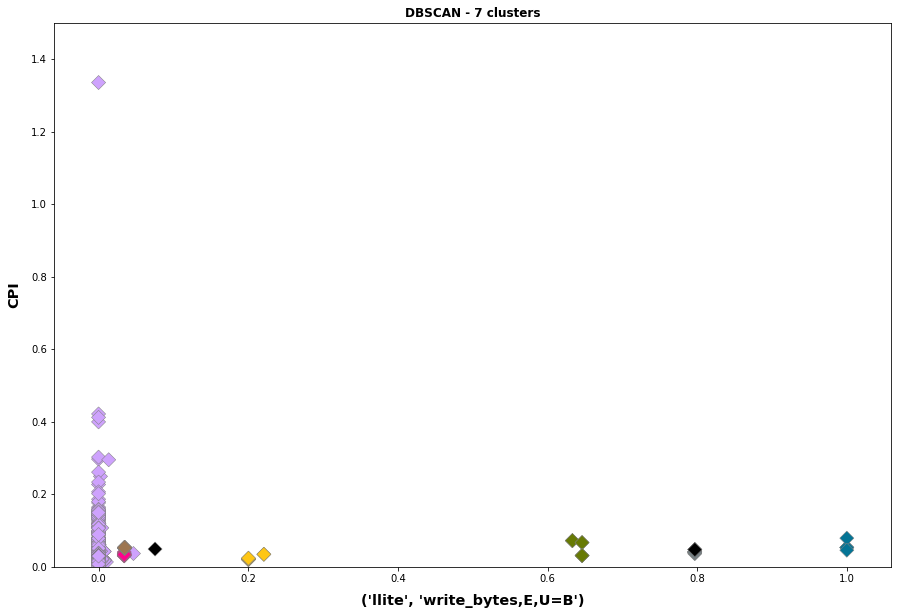

In [177]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( X.values[:,4], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[4]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('osc', 'read_bytes,E,U=B')")

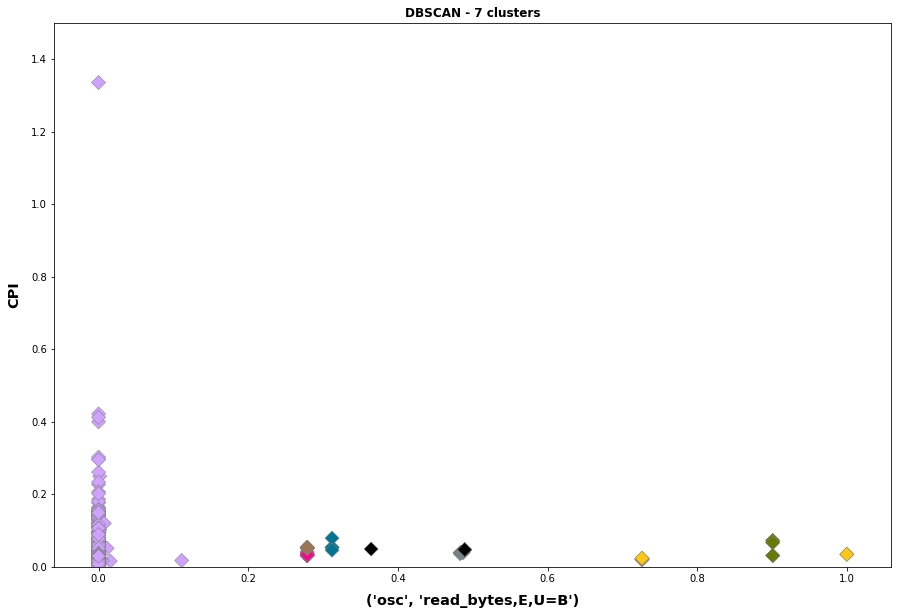

In [178]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( X.values[:,10], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[10]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('osc', 'write_bytes,E,U=B')")

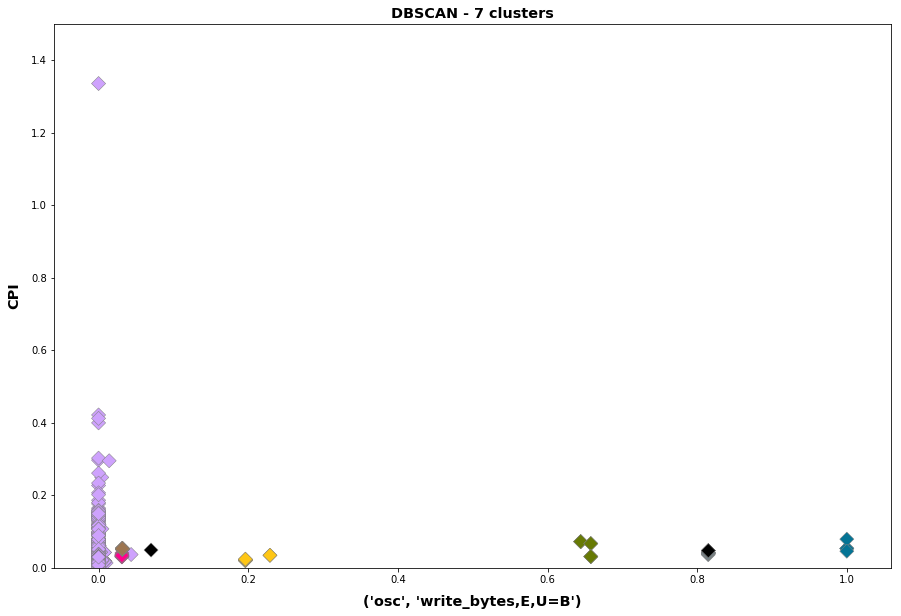

In [182]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( X.values[:,11], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', fontsize='x-large', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[11]}', labelpad=10, weight='bold', fontsize='x-large')

#### Grab indices of important labels to check important ids

In [44]:
groups = { val:[] for val in n_groups }
core_ids = { val:[] for val in n_groups }

for i in range( len( models[0].labels_ ) ):
    label = models[0].labels_[ i ]
    if label > -1:
        groups[ label ].append( i )
        
for group_n, i_list in groups.items():
    for i in i_list:
        core_ids[ group_n ].append( found_ids[ i ] )

In [45]:
total_core_samples = sum([ len(id_list) for id_list in core_ids.values() ])
total_core_samples

490

#### Inspect important jobids for acct_info commonality

In [46]:
core_jobs = { val:[] for val in n_groups }
done = []

for item in valid:
    this_id = item["JobID"]
    
    for group_n, id_list in core_ids.items():
        if (this_id in id_list) and not( this_id in done ):
            core_jobs[ group_n ].append( item )
            done.append(this_id)

In [47]:
for group,group_list in core_jobs.items():
    print(f'Group label:\t{group}')
    print(f'Count:\t{len(group_list)}')
    print()

Group label:	0
Count:	179

Group label:	1
Count:	4

Group label:	2
Count:	2

Group label:	3
Count:	4

Group label:	4
Count:	3

Group label:	5
Count:	5

Group label:	6
Count:	5



# Same DBSCAN model, showing unscaled agg_df on X axis

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('block', 'rd_ios,E')")

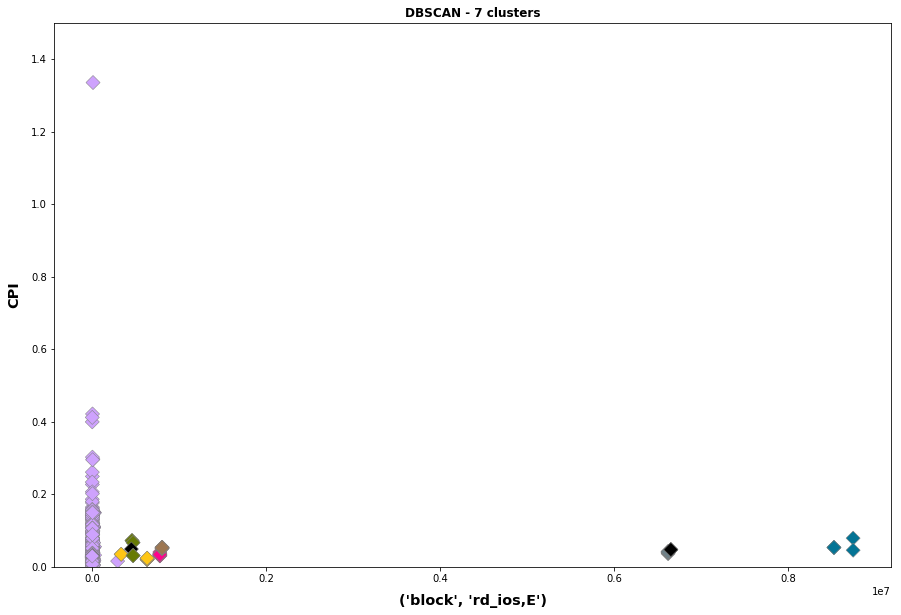

In [183]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( agg_df.values[:,0], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[0]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('block', 'wr_ios,E')")

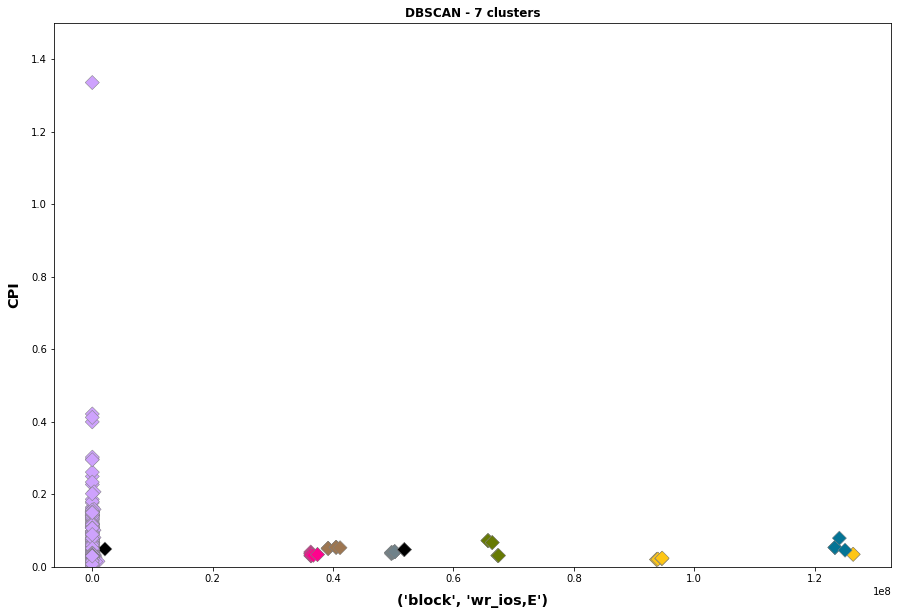

In [184]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( agg_df.values[:,1], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[1]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('cpu', 'idle,E,U=cs')")

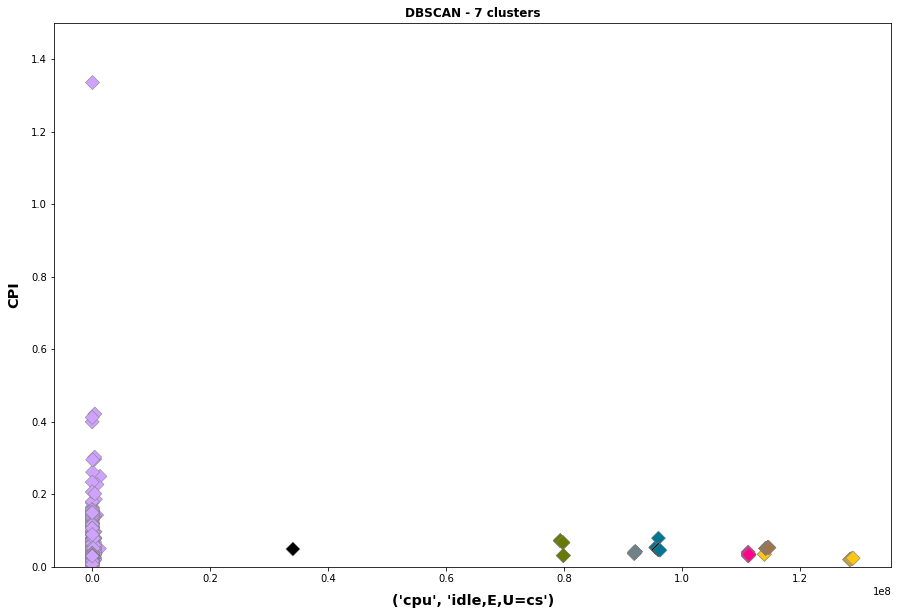

In [186]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( agg_df.values[:,2], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[2]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('llite', 'write_bytes,E,U=B')")

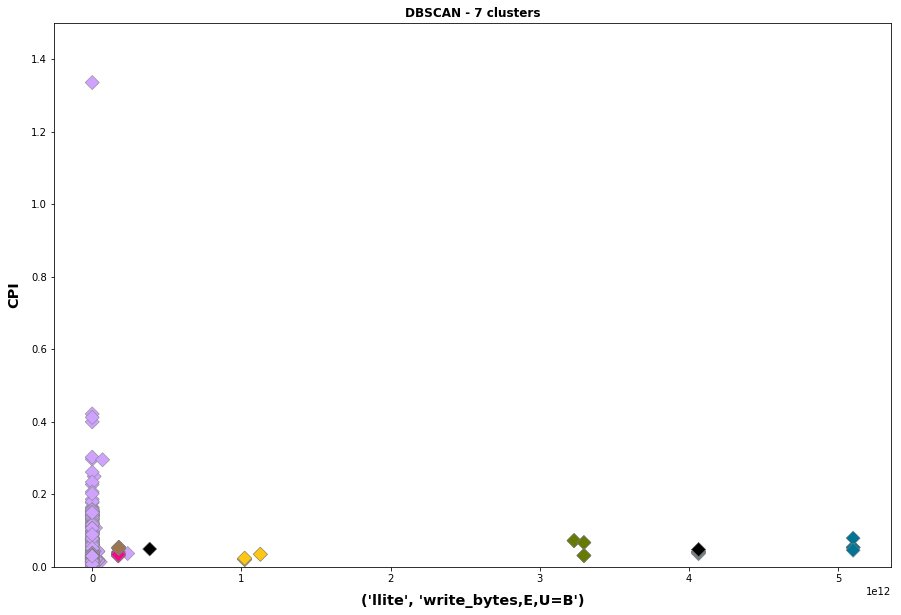

In [187]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( agg_df.values[:,4], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[4]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('osc', 'read_bytes,E,U=B')")

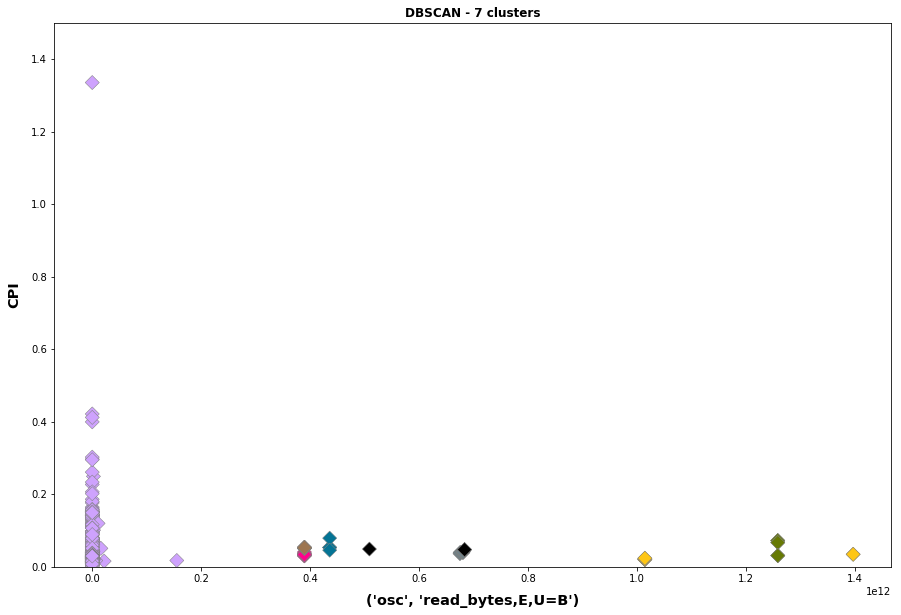

In [188]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( agg_df.values[:,10], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[10]}', labelpad=10, weight='bold', fontsize='x-large')

Estimated no. of clusters: 7
Estimated no. of noise points: 11


Text(0.5, 0, "('osc', 'write_bytes,E,U=B')")

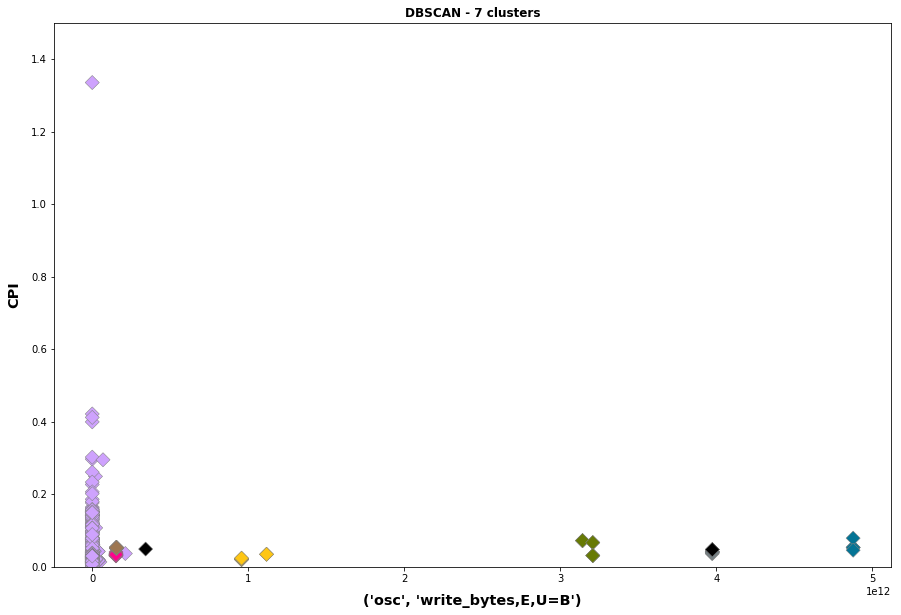

In [189]:
DB_model = models[0]
X_comps = DB_model.components_

n_clusters = len(n_groups)
n_noise = np.sum(np.array(labels) == -1, axis=0)

print(f'Estimated no. of clusters: {n_clusters}')
print(f'Estimated no. of noise points: {n_noise}')

colors_dict = {
    -1: '#000000',
    0: '#cea2fd',
    1: '#ff028d',
    2: '#6f828a',
    3: '#677a04',
    4: '#047495',
    5: '#fec615',
    6: '#9d7651'
}
colors = list(map(lambda x: colors_dict[x], labels))

fig, ax = plt.subplots( figsize=(15, 10) )

ax.set_ylim([0, 1.5])
ax.scatter( agg_df.values[:,11], Y.values, s=100, c=colors, marker='D', linewidths=0.5, edgecolors='gray' )
ax.set_title( f'DBSCAN - {n_clusters} clusters', weight='bold' )
ax.set_ylabel('CPI', labelpad=10, weight='bold', fontsize='x-large')
ax.set_xlabel(f'{X.columns[11]}', labelpad=10, weight='bold', fontsize='x-large')